## PDS API demo
# Visualization of Osiris-Rex OVIRS spectrometer observations of asteroid BENNU

The purpose of this notebook is to demostrate how the PDS web API can be used to access the PDS data for a scientific use case.

The documention of the PDS web API is available on https://nasa-pds.github.io/pds-api/

This notebook is available on https://github.com/NASA-PDS/pds-api-notebook

 
<b>WARNING:</b> This notebook is a demo and not a real scientific use case. It might contain mistakes in the way the data is used or displayed.

In [116]:
from __future__ import print_function
from pprint import pprint
from IPython.lib.pretty import pretty
import time
import matplotlib.pyplot as plt
from astropy.io import fits

The PDS API is accessed using a python client library documented on https://nasa-pds.github.io/pds-api-client/

In [87]:
import pds.api_client as pds_api

## Use the PDS demo web API server 

Connect to the production server. See User Interface of the web API: https://pds.nassa.gov/api/search/1/

<b>Note: </b> this piece of code will be wrapped into a helper function so that 1 line will be enough to connect to the API using a default host

In [88]:
configuration = pds_api.Configuration()

# production server
configuration.host = 'https://pds.nasa.gov/api/search/1/'
api_client = pds_api.ApiClient(configuration)


## List requestable properties

Available properties can be identified with a request, for example, searching for products which match free text search on `ovir`.

Properties are defined in:
- core dictionnary (pds: prefix) : https://pds.nasa.gov/datastandards/dictionaries/index-1.20.0.0.shtml#pds-common
- displine dictionnaries (e.g. geom:) : https://pds.nasa.gov/datastandards/dictionaries/index-1.19.0.0.shtml#discipline-dictionaries
- mission dictionnaries (e.g. orex:) : https://pds.nasa.gov/datastandards/dictionaries/index-missions.shtml#mission-dictionaries

In [121]:
from pds.api_client.api.all_products_api import AllProductsApi

products = AllProductsApi(api_client)
api_response = products.product_list(keywords=['ovir'])
api_response.summary.properties


['_package_id',
 'alternate_ids',
 'description',
 'disp:Display_Direction.disp:horizontal_display_axis',
 'disp:Display_Direction.disp:horizontal_display_direction',
 'disp:Display_Direction.disp:vertical_display_axis',
 'disp:Display_Direction.disp:vertical_display_direction',
 'geom:Geometry_Orbiter.geom:geometry_reference_time_tdb',
 'geom:Geometry_Orbiter.geom:geometry_reference_time_utc',
 'geom:SPICE_Kernel_Identification.geom:kernel_provenance',
 'geom:SPICE_Kernel_Identification.geom:kernel_type',
 'geom:SPICE_Kernel_Identification.geom:spice_kernel_file_name',
 'lid',
 'lidvid',
 'ops:Data_File_Info.ops:creation_date_time',
 'ops:Data_File_Info.ops:file_name',
 'ops:Data_File_Info.ops:file_ref',
 'ops:Data_File_Info.ops:file_size',
 'ops:Data_File_Info.ops:md5_checksum',
 'ops:Data_File_Info.ops:mime_type',
 'ops:Harvest_Info.ops:harvest_date_time',
 'ops:Harvest_Info.ops:node_name',
 'ops:Label_File_Info.ops:creation_date_time',
 'ops:Label_File_Info.ops:file_name',
 'ops:La

## Get observations around specific spot (lat=12, lon=24) with distance to bennu closer than 4 km

Get the result found in part1 by directly posting the search criteria to the API

We use `AllProductsApi.product_list(...)` with argument `q=`.

See detailed method documentation on https://nasa-pds.github.io/pds-api-client/api/pds.api_client.api.all_products_api.html#pds.api_client.api.all_products_api.AllProductsApi.product_list

The query syntax uses the following operators:
- comparison: lt, le, ...
- boolean: and, or, not
- groups: (, )

See https://github.com/NASA-PDS/pds-api/blob/master/docs/spec/pds-api-specification.md#query-syntax for detailed syntax.

We request the FITS data file url from the API in the `field=` argument.

In [107]:
start_time = time.time() 

criteria = ' ( ( ref_lid_target eq "urn:nasa:pds:context:target:asteroid.101955_bennu" )'
criteria += ' and ( ref_lid_instrument eq "urn:nasa:pds:context:instrument:ovirs.orex" ) '
criteria += ' and ( orex:Spatial.orex:target_range lt 4.0 )'
criteria += " and ( orex:Spatial.orex:latitude ge 9.0 ) and ( orex:Spatial.orex:latitude le 15.0 )"
criteria += " and ( orex:Spatial.orex:longitude ge 21.0 ) and ( orex:Spatial.orex:longitude le 27.0 )"
criteria += ' ) '

properties_of_interest = ['ref_lid_target', 'ref_lid_instrument', 'orex:Spatial.orex:latitude', 'orex:Spatial.orex:longitude', 'ref_lid_instrument', 'orex:Spatial.orex:target_range', 'ops:Data_File_Info.ops:file_ref']
start = 0
limit = 500
prods = []

api_response = products.product_list(
    q=criteria,
    start=start, 
    limit=limit,
    fields=properties_of_interest
)

closer_products = api_response.data

elapsed = time.time() - start_time

## Structure of the reponse

The responses are JSON objects, as follow

In [120]:
pprint(closer_products[0].to_dict())

{'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204130s368_ovr_scil2_calv2.fits::2.0',
 'investigations': [{'href': 'https://pds.nasa.gov/api/search/1/products/urn:nasa:pds:context:investigation:mission.orex',
                     'id': 'urn:nasa:pds:context:investigation:mission.orex'}],
 'metadata': {'creation_date_time': '2022-03-03T05:37:55.757Z',
              'label_url': 'https://sbnarchive.psi.edu/pds4/orex/orex.ovirs/data_calibrated/detailed_survey/20190321T204130S368_ovr_scil2_calv2.xml',
              'update_date_time': '2019-02-01T00:00:00Z',
              'version': '2.0'},
 'observing_system_components': [{'href': 'https://pds.nasa.gov/api/search/1/products/urn:nasa:pds:context:instrument_host:spacecraft.orex',
                                  'id': 'urn:nasa:pds:context:instrument_host:spacecraft.orex'},
                                 {'href': 'https://pds.nasa.gov/api/search/1/products/urn:nasa:pds:context:instrument:ovirs.orex',
                           

### Check that we have the right lidvids

In [110]:
lidvids = [product.id for product in closer_products]
print(f'The lidvids of the selected products are {lidvids}')

The lidvids of the selected products are ['urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204130s368_ovr_scil2_calv2.fits::2.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204128s567_ovr_scil2_calv2.fits::2.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204129s468_ovr_scil2_calv2.fits::2.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204131s368_ovr_scil2_calv2.fits::2.0']


### Extract the links to the data files

In [113]:
data_files = [product.properties['ops:Data_File_Info.ops:file_ref'][0] for product in closer_products]
print(f"product data file url: {data_files}")

product data file url: ['https://sbnarchive.psi.edu/pds4/orex/orex.ovirs/data_calibrated/detailed_survey/20190321T204130S368_ovr_scil2_calv2.fits', 'https://sbnarchive.psi.edu/pds4/orex/orex.ovirs/data_calibrated/detailed_survey/20190321T204128S567_ovr_scil2_calv2.fits', 'https://sbnarchive.psi.edu/pds4/orex/orex.ovirs/data_calibrated/detailed_survey/20190321T204129S468_ovr_scil2_calv2.fits', 'https://sbnarchive.psi.edu/pds4/orex/orex.ovirs/data_calibrated/detailed_survey/20190321T204131S368_ovr_scil2_calv2.fits']


## Plot the data (FITS files)

Plot the spectra of the 4 observations on the same figure, one figure per dimension of the instrument.


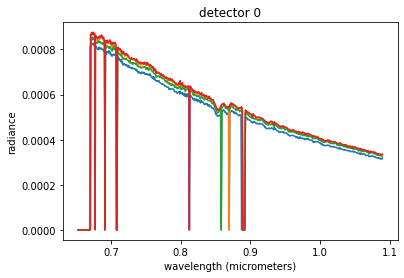

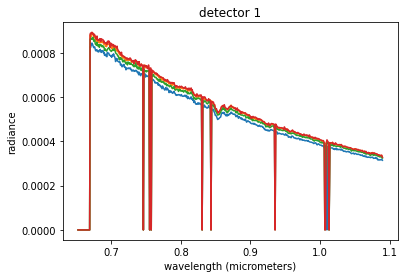

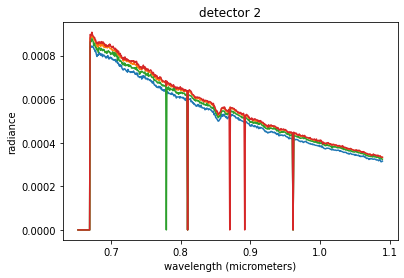

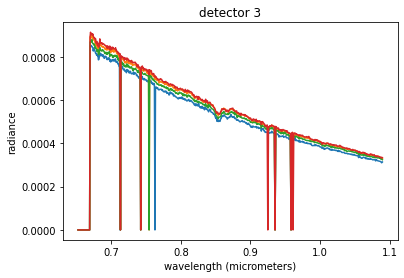

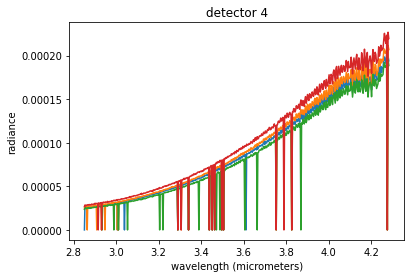

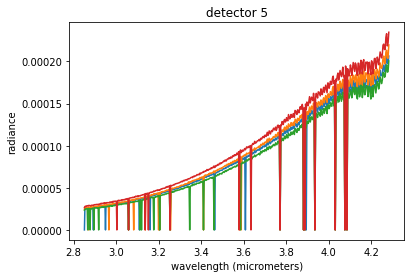

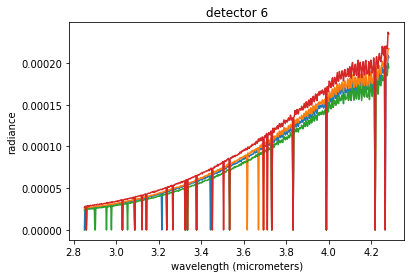

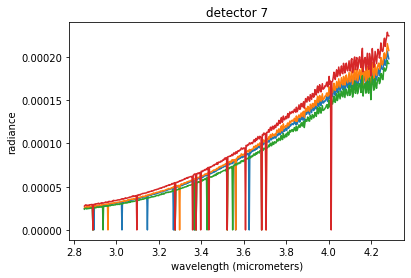

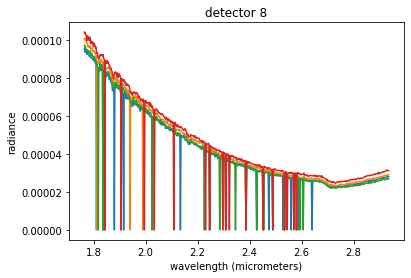

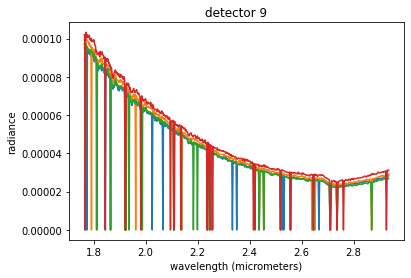

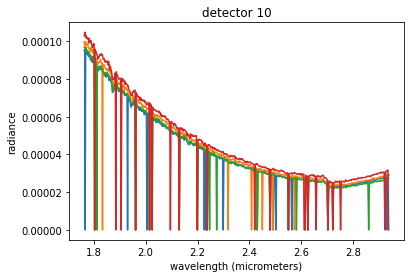

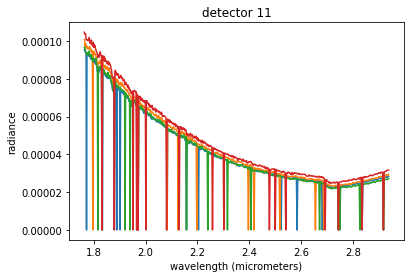

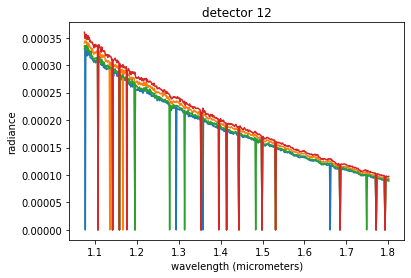

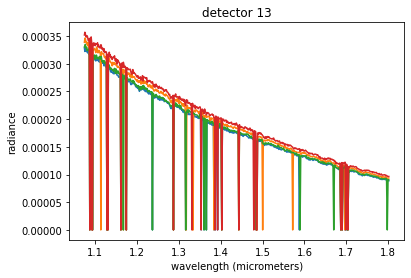

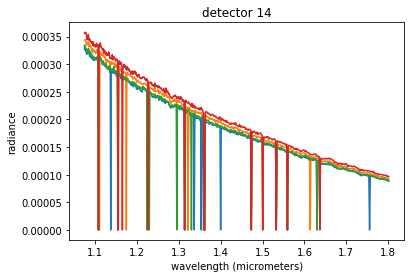

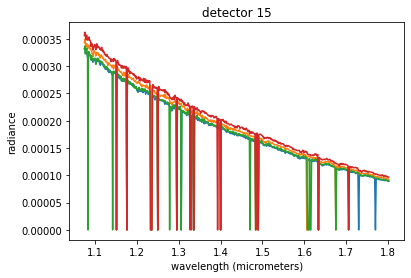

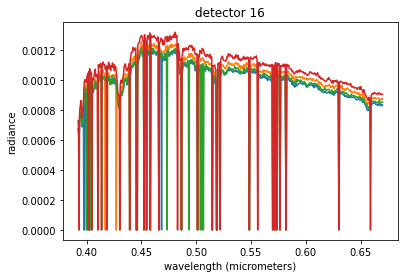

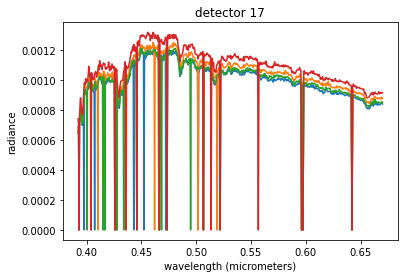

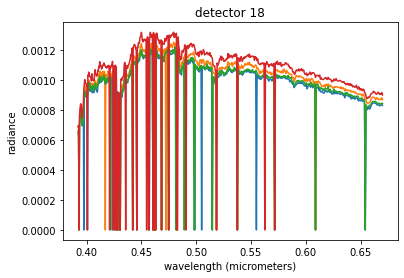

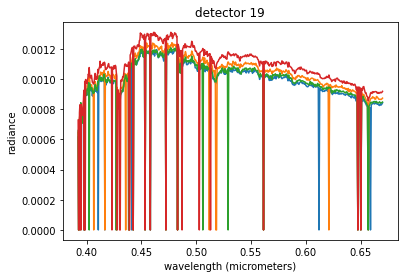

In [114]:
hduls = [fits.open(data_file) for data_file in data_files]

for i in range(20): # for each dimension of the instrument
    fig, ax = plt.subplots()
    ax.set_title(f'detector {i}')
    for hdul in hduls: # for each observation
        ax.plot(hdul[2].data[0, i, :], hdul[0].data[0, i, :])
    ax.set_xlabel('wavelength (micrometers)')
    ax.set_ylabel('radiance')